# MNIST INT8 Classification on ESP32-P4 using P4-JIT

## ✅ Complete Fixed Pipeline

**Key Fixes:**
- ✅ **Correct bias scaling**: `bias × 2^E_in` (not `2^(E_in+E_w-E_out)`)
- ✅ **Input quantization** from the start
- ✅ **Proper preprocessing** match between training and deployment
- ✅ **Individual scale exponents** passed to C for clarity
- ✅ **Smart Args** for clean NumPy interface
- ✅ **Verification steps** at each stage

---

## 1. Setup & Environment

In [2]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import time

# Setup directories
NOTEBOOK_DIR = Path.cwd()
SOURCE_DIR = NOTEBOOK_DIR / "source"
WEIGHTS_DIR = NOTEBOOK_DIR / "weights"
RESULTS_DIR = NOTEBOOK_DIR / "results"

for d in [SOURCE_DIR, WEIGHTS_DIR, RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Add P4-JIT
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent.parent
sys.path.append(str(PROJECT_ROOT / "host"))

from p4jit import P4JIT, MALLOC_CAP_SPIRAM, MALLOC_CAP_8BIT
import p4jit

# Seed
torch.manual_seed(42)
np.random.seed(42)

print("✓ Environment ready")
print(f"✓ PyTorch: {torch.__version__}")
print(f"✓ Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

✓ Environment ready
✓ PyTorch: 2.8.0+cu126
✓ Device: CUDA


## 2. Dataset Preparation

**Important:** MNIST images are normalized with `mean=0.1307, std=0.3081` during training.

✓ Train: 60,000 | Test: 10,000


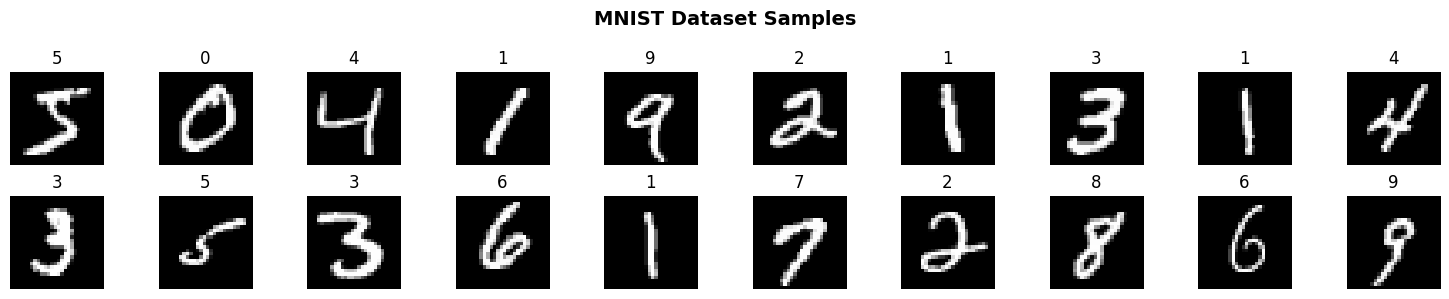

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"✓ Train: {len(train_dataset):,} | Test: {len(test_dataset):,}")

# Visualize (denormalized for display)
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(20):
    img, label = train_dataset[i]
    # Denormalize for visualization
    img_display = img.squeeze() * 0.3081 + 0.1307
    ax = axes[i // 10, i % 10]
    ax.imshow(img_display, cmap='gray')
    ax.set_title(f'{label}')
    ax.axis('off')
plt.suptitle('MNIST Dataset Samples', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'dataset.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Quantization Modules

**Power-of-2 scales** with Straight-Through Estimator for gradients.

In [4]:
class PowerOfTwoQuantize(torch.autograd.Function):
    """INT8 quantization with Straight-Through Estimator"""
    @staticmethod
    def forward(ctx, x, scale_exp):
        scale = 2.0 ** scale_exp
        x_q = torch.clamp(torch.round(x * scale), -128, 127)
        x_dq = x_q / scale
        return x_dq
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output, None


class FakeQuantizeINT8(nn.Module):
    def __init__(self):
        super().__init__()
        self.register_buffer('scale_exp', torch.tensor(0))
        self.enabled = False
        
    def set_scale_exp(self, exp):
        self.scale_exp = torch.tensor(exp)
        
    def enable(self):
        self.enabled = True
        
    def forward(self, x):
        if not self.enabled:
            return x
        return PowerOfTwoQuantize.apply(x, self.scale_exp)
    
    def get_scale_info(self):
        exp = int(self.scale_exp.item())
        scale = 2.0 ** (-exp)
        return exp, scale


class QuantizedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.weight_quant = FakeQuantizeINT8()
        
    def forward(self, x):
        w_q = self.weight_quant(self.conv.weight)
        return F.conv2d(x, w_q, self.conv.bias, 
                       self.conv.stride, self.conv.padding, 
                       self.conv.dilation, self.conv.groups)


class QuantizedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.weight_quant = FakeQuantizeINT8()
        
    def forward(self, x):
        w_q = self.weight_quant(self.linear.weight)
        return F.linear(x, w_q, self.linear.bias)


print("✓ Quantization modules defined")

✓ Quantization modules defined


## 4. Model Architecture

**With input quantization from the start!**

In [5]:
class QuantizedMNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Input quantization
        self.input_quant = FakeQuantizeINT8()
        
        # Conv layers
        self.conv1 = QuantizedConv2d(1, 16, kernel_size=3, padding=1)
        self.act1_quant = FakeQuantizeINT8()
        
        self.conv2 = QuantizedConv2d(16, 32, kernel_size=3, padding=1)
        self.act2_quant = FakeQuantizeINT8()
        
        # FC layers
        self.fc1 = QuantizedLinear(32 * 7 * 7, 128)
        self.act3_quant = FakeQuantizeINT8()
        
        self.fc2 = QuantizedLinear(128, 10)
        
    def forward(self, x):
        x = self.input_quant(x)
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.act1_quant(x)
        x = F.max_pool2d(x, 2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.act2_quant(x)
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.act3_quant(x)
        
        x = self.fc2(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = QuantizedMNISTNet().to(device)

print(f"✓ Model: {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"✓ Input quantization: ENABLED")
print(model)

✓ Model: 206,922 parameters
✓ Input quantization: ENABLED
QuantizedMNISTNet(
  (input_quant): FakeQuantizeINT8()
  (conv1): QuantizedConv2d(
    (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (weight_quant): FakeQuantizeINT8()
  )
  (act1_quant): FakeQuantizeINT8()
  (conv2): QuantizedConv2d(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (weight_quant): FakeQuantizeINT8()
  )
  (act2_quant): FakeQuantizeINT8()
  (fc1): QuantizedLinear(
    (linear): Linear(in_features=1568, out_features=128, bias=True)
    (weight_quant): FakeQuantizeINT8()
  )
  (act3_quant): FakeQuantizeINT8()
  (fc2): QuantizedLinear(
    (linear): Linear(in_features=128, out_features=10, bias=True)
    (weight_quant): FakeQuantizeINT8()
  )
)


## 5. Training: Warmup → Calibration → QAT

In [6]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0, 0
    for data, target in tqdm(loader, desc='Training', leave=False):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += output.argmax(dim=1).eq(target).sum().item()
    return total_loss / len(loader), 100. * correct / len(loader.dataset)


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output, target).item()
            correct += output.argmax(dim=1).eq(target).sum().item()
    return total_loss / len(loader), 100. * correct / len(loader.dataset)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

WARMUP_EPOCHS = 2
QAT_EPOCHS = 2
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

# Phase 1: Warmup
print("\n" + "="*80)
print("PHASE 1: WARMUP (FP32)")
print("="*80)

for epoch in range(1, WARMUP_EPOCHS + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    print(f"Epoch {epoch}/{WARMUP_EPOCHS} | Train: {train_acc:.2f}% | Test: {test_acc:.2f}%")

print(f"✓ Warmup complete: {history['test_acc'][-1]:.2f}%")


PHASE 1: WARMUP (FP32)


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/2 | Train: 93.79% | Test: 98.28%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/2 | Train: 98.16% | Test: 98.42%
✓ Warmup complete: 98.42%


### Calibration

In [7]:
def calculate_scale_exponent(tensor):
    max_val = tensor.abs().max().item()
    if max_val == 0:
        return 0
    import math
    return math.floor(math.log2(127.0 / max_val))


def calibrate_activations(model, loader, device, num_batches=10):
    model.eval()
    activation_stats = {}
    
    def get_hook(name):
        def hook(module, input, output):
            if name not in activation_stats:
                activation_stats[name] = []
            activation_stats[name].append(output.abs().max().item())
        return hook
    
    hooks = []
    
    # Hook for input
    def input_hook(module, input):
        if 'input_quant' not in activation_stats:
            activation_stats['input_quant'] = []
        activation_stats['input_quant'].append(input[0].abs().max().item())
    
    hooks.append(model.register_forward_pre_hook(input_hook))
    
    # Hooks for activations
    for name, module in model.named_modules():
        if 'act' in name and isinstance(module, FakeQuantizeINT8):
            parent_name = '.'.join(name.split('.')[:-1])
            if parent_name:
                parent = dict(model.named_modules())[parent_name]
            else:
                parent = module
            hooks.append(parent.register_forward_hook(get_hook(name)))

    
    with torch.no_grad():
        for i, (data, _) in enumerate(loader):
            if i >= num_batches:
                break
            model(data.to(device))
    
    for hook in hooks:
        hook.remove()
    
    exponents = {}
    for name, values in activation_stats.items():
        max_val = max(values)
        import math
        exp = math.floor(math.log2(127.0 / max_val)) if max_val > 0 else 0
        exponents[name] = exp
    
    return exponents


print("\n" + "="*80)
print("PHASE 2: CALIBRATION")
print("="*80)

# Weights
print("\nWeight calibration:")
for name, module in model.named_modules():
    if isinstance(module, (QuantizedConv2d, QuantizedLinear)):
        weight = module.conv.weight if isinstance(module, QuantizedConv2d) else module.linear.weight
        exp = calculate_scale_exponent(weight.data)
        module.weight_quant.set_scale_exp(exp)
        print(f"  {name:20s} → Exp: {exp:+3d} (scale: 2^{exp})")

# Activations
print("\nActivation calibration:")
act_exponents = calibrate_activations(model, train_loader, device, num_batches=10)
for name, module in model.named_modules():
    if isinstance(module, FakeQuantizeINT8) and name in act_exponents:
        exp = act_exponents[name]
        module.set_scale_exp(exp)
        print(f"  {name:20s} → Exp: {exp:+3d} (scale: 2^{exp})")

print("\n✓ Calibration complete")


PHASE 2: CALIBRATION

Weight calibration:
  conv1                → Exp:  +7 (scale: 2^7)
  conv2                → Exp:  +8 (scale: 2^8)
  fc1                  → Exp:  +9 (scale: 2^9)
  fc2                  → Exp:  +9 (scale: 2^9)

Activation calibration:
  input_quant          → Exp:  +5 (scale: 2^5)
  act1_quant           → Exp:  +4 (scale: 2^4)
  act2_quant           → Exp:  +4 (scale: 2^4)
  act3_quant           → Exp:  +2 (scale: 2^2)

✓ Calibration complete


### QAT Phase

In [8]:
# Enable quantization
for module in model.modules():
    if isinstance(module, FakeQuantizeINT8):
        module.enable()

print("\n" + "="*80)
print("PHASE 3: QUANTIZATION-AWARE TRAINING")
print("="*80)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

for epoch in range(1, QAT_EPOCHS + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    total_epoch = WARMUP_EPOCHS + epoch
    print(f"Epoch {total_epoch}/{WARMUP_EPOCHS + QAT_EPOCHS} | Train: {train_acc:.2f}% | Test: {test_acc:.2f}%")

print("\n" + "="*80)
print(f"✓ Final Test Accuracy: {history['test_acc'][-1]:.2f}%")
print("="*80)


PHASE 3: QUANTIZATION-AWARE TRAINING


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/4 | Train: 98.86% | Test: 98.65%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/4 | Train: 99.12% | Test: 98.80%

✓ Final Test Accuracy: 98.80%


## 6. Extract Quantized Weights

**Store all scale exponents for C code**

In [9]:
def quantize_to_int8(tensor, scale_exp):
    scale = 2.0 ** scale_exp
    quantized = torch.clamp(torch.round(tensor * scale), -128, 127).to(torch.int8)
    return quantized.cpu().numpy()


model.eval()
quantized_weights = {}
scale_exponents = {}

print("\n" + "="*80)
print("WEIGHT EXTRACTION")
print("="*80)

# Input
input_exp, _ = model.input_quant.get_scale_info()
scale_exponents['input'] = input_exp
print(f"\nInput: E_in = {input_exp}")

# Conv1
w_exp, _ = model.conv1.weight_quant.get_scale_info()
act_exp, _ = model.act1_quant.get_scale_info()
w = quantize_to_int8(model.conv1.conv.weight.data, w_exp)
b = quantize_to_int8(model.conv1.conv.bias.data, w_exp)
quantized_weights['conv1'] = {'weight': w, 'bias': b}
scale_exponents['conv1'] = {'w': w_exp, 'act': act_exp}
print(f"Conv1: E_w={w_exp:+3d}, E_act={act_exp:+3d}, W_shape={w.shape}")

# Conv2
w_exp, _ = model.conv2.weight_quant.get_scale_info()
act_exp, _ = model.act2_quant.get_scale_info()
w = quantize_to_int8(model.conv2.conv.weight.data, w_exp)
b = quantize_to_int8(model.conv2.conv.bias.data, w_exp)
quantized_weights['conv2'] = {'weight': w, 'bias': b}
scale_exponents['conv2'] = {'w': w_exp, 'act': act_exp}
print(f"Conv2: E_w={w_exp:+3d}, E_act={act_exp:+3d}, W_shape={w.shape}")

# FC1
w_exp, _ = model.fc1.weight_quant.get_scale_info()
act_exp, _ = model.act3_quant.get_scale_info()
w = quantize_to_int8(model.fc1.linear.weight.data, w_exp)
b = quantize_to_int8(model.fc1.linear.bias.data, w_exp)
quantized_weights['fc1'] = {'weight': w, 'bias': b}
scale_exponents['fc1'] = {'w': w_exp, 'act': act_exp}
print(f"FC1:   E_w={w_exp:+3d}, E_act={act_exp:+3d}, W_shape={w.shape}")

# FC2
w_exp, _ = model.fc2.weight_quant.get_scale_info()
w = quantize_to_int8(model.fc2.linear.weight.data, w_exp)
b = quantize_to_int8(model.fc2.linear.bias.data, w_exp)
quantized_weights['fc2'] = {'weight': w, 'bias': b}
scale_exponents['fc2'] = {'w': w_exp}
print(f"FC2:   E_w={w_exp:+3d}, W_shape={w.shape}")

total_params = sum(w['weight'].size + w['bias'].size for w in quantized_weights.values())
print(f"\n✓ Total: {total_params:,} bytes ({total_params/1024:.2f} KB)")
print("="*80)


WEIGHT EXTRACTION

Input: E_in = 5
Conv1: E_w= +7, E_act= +4, W_shape=(16, 1, 3, 3)
Conv2: E_w= +8, E_act= +4, W_shape=(32, 16, 3, 3)
FC1:   E_w= +9, E_act= +2, W_shape=(128, 1568)
FC2:   E_w= +9, W_shape=(10, 128)

✓ Total: 206,922 bytes (202.07 KB)


## 7. C Implementation with FIXED Bias Scaling

### The Correct Math:

```
Accumulator = Σ(input_q × weight_q)
            = Σ((input × 2^E_in) × (weight × 2^E_w))
            = (Σ input × weight) × 2^(E_in + E_w)

Bias at scale 2^E_w needs to be brought to scale 2^(E_in + E_w):
  bias_scaled = bias_q × 2^E_in

Then scale to output:
  output_q = (acc + bias_scaled) >> (E_in + E_w - E_out)
```

In [10]:
c_code = """#include <stdint.h>
#include <stdio.h>

// Read RISC-V cycle counter
static inline uint32_t rdcycle(void) {
    uint32_t cycles;
    asm volatile ("rdcycle %0" : "=r"(cycles));
    return cycles;
}

static inline int32_t relu_int32(int32_t x) { return (x > 0) ? x : 0; }
static inline int8_t clip_int8(int32_t x) {
    return (x > 127) ? 127 : ((x < -128) ? -128 : (int8_t)x);
}

// Conv2d with ReLU BEFORE quantization
void conv2d_int8(
    const int8_t* input, int in_h, int in_w, int in_c,
    const int8_t* weight, const int8_t* bias,
    int8_t* output, int out_c,
    int exp_in, int exp_w, int exp_out
) {
    const int K = 3, P = 1, S = 1;
    int out_h = (in_h + 2*P - K) / S + 1;
    int out_w = (in_w + 2*P - K) / S + 1;
    
    int acc_shift = exp_in + exp_w - exp_out;
    
    for (int oc = 0; oc < out_c; oc++) {
        for (int oh = 0; oh < out_h; oh++) {
            for (int ow = 0; ow < out_w; ow++) {
                int32_t acc = 0;
                
                // MAC
                for (int ic = 0; ic < in_c; ic++) {
                    for (int kh = 0; kh < K; kh++) {
                        for (int kw = 0; kw < K; kw++) {
                            int ih = oh * S - P + kh;
                            int iw = ow * S - P + kw;
                            
                            if (ih >= 0 && ih < in_h && iw >= 0 && iw < in_w) {
                                acc += (int32_t)input[(ic * in_h + ih) * in_w + iw] *
                                       (int32_t)weight[((oc * in_c + ic) * K + kh) * K + kw];
                            }
                        }
                    }
                }
                
                // Add bias (scaled by E_in)
                acc += (int32_t)bias[oc] << exp_in;
                
                // ReLU BEFORE quantization
                acc = relu_int32(acc);
                
                // Scale to output
                acc = acc >> acc_shift;
                
                output[(oc * out_h + oh) * out_w + ow] = clip_int8(acc);
            }
        }
    }
}

void maxpool2d_int8(const int8_t* input, int8_t* output, int h, int w, int c) {
    int out_h = h / 2, out_w = w / 2;
    for (int ch = 0; ch < c; ch++) {
        for (int oh = 0; oh < out_h; oh++) {
            for (int ow = 0; ow < out_w; ow++) {
                int8_t max_val = -128;
                for (int kh = 0; kh < 2; kh++) {
                    for (int kw = 0; kw < 2; kw++) {
                        int8_t v = input[(ch * h + oh*2 + kh) * w + ow*2 + kw];
                        if (v > max_val) max_val = v;
                    }
                }
                output[(ch * out_h + oh) * out_w + ow] = max_val;
            }
        }
    }
}

// FC layer with ReLU BEFORE quantization
void fc_int8(
    const int8_t* input, int in_size,
    const int8_t* weight, const int8_t* bias,
    int8_t* output, int out_size,
    int exp_in, int exp_w, int exp_out
) {
    int acc_shift = exp_in + exp_w - exp_out;
    
    for (int i = 0; i < out_size; i++) {
        int32_t acc = 0;
        for (int j = 0; j < in_size; j++) {
            acc += (int32_t)input[j] * (int32_t)weight[i * in_size + j];
        }
        
        // Add bias (scaled by E_in)
        acc += (int32_t)bias[i] << exp_in;
        
        // ReLU BEFORE quantization
        acc = relu_int32(acc);
        
        // Scale to output
        acc = acc >> acc_shift;
        
        output[i] = clip_int8(acc);
    }
}

// FC layer WITHOUT quantization (for final layer)
void fc_int32(
    const int8_t* input, int in_size,
    const int8_t* weight, const int8_t* bias,
    int32_t* output, int out_size,
    int exp_in, int exp_w
) {
    for (int i = 0; i < out_size; i++) {
        int32_t acc = 0;
        for (int j = 0; j < in_size; j++) {
            acc += (int32_t)input[j] * (int32_t)weight[i * in_size + j];
        }
        
        // Add bias (scaled by E_in)
        acc += (int32_t)bias[i] << exp_in;
        
        // NO ReLU, NO quantization - raw logits
        output[i] = acc;
    }
}

void fc_int32_p4simd(
    const int8_t* input, int in_size,
    const int8_t* weight, const int8_t* bias,
    int32_t* output, int out_size,
    int exp_in, int exp_w
) {
    // Current pointer to weights (increments monotonically)
    const int8_t* w_ptr = weight;
    
    // Calculate loop iterations (16 bytes per iteration)
    int loop_count = in_size >> 4; 

    for (int i = 0; i < out_size; i++) {
        const int8_t* in_ptr = input;
        int32_t acc_val;
        int shift_amt = 0; // Shift amount for result extraction

        asm volatile (
            "esp.zero.accx \\n\\t"                  // Clear accumulator
            "lp.setup 0, %[cnt], 1f \\n\\t"         // Setup HW loop 0
            "lp.start 0 \\n\\t"                     // Start HW loop 0
            "0: \\n\\t"                             // Loop body start label
            "esp.vld.128.ip q0, %[in], 16 \\n\\t"   // Load 16 inputs, ptr+=16
            "esp.vld.128.ip q1, %[w], 16 \\n\\t"    // Load 16 weights, ptr+=16
            "esp.vmulas.s8.accx q0, q1 \\n\\t"      // Multiply & Accumulate
            "1: \\n\\t"                             // Loop end label
            "esp.srs.accx %[res], %[shft], 0 \\n\\t" // Extract result to GPR

            // Output Operands
            : [res] "=r" (acc_val),       // Output: Result value
              [in]  "+r" (in_ptr),        // Read/Write: Input pointer
              [w]   "+r" (w_ptr)          // Read/Write: Weight pointer
            
            // Input Operands
            : [cnt] "r" (loop_count),     // Input: Loop count
              [shft] "r" (shift_amt)      // Input: Shift amount (0)
            
            // Clobbers
            : "memory"
        );

        // Post-processing: Add bias and scale (Scalar operations)
        output[i] = acc_val + ((int32_t)bias[i] << exp_in);
    }
}

// Inference function WITH TIMING
int32_t mnist_inference(
    int8_t* input,
    int8_t* w_conv1, int8_t* b_conv1,
    int8_t* w_conv2, int8_t* b_conv2,
    int8_t* w_fc1, int8_t* b_fc1,
    int8_t* w_fc2, int8_t* b_fc2,
    int32_t e_in,
    int32_t e_conv1_w, int32_t e_conv1_act,
    int32_t e_conv2_w, int32_t e_conv2_act,
    int32_t e_fc1_w, int32_t e_fc1_act,
    int32_t e_fc2_w,
    int8_t* scratch,
    uint32_t* timing  
) {
    // Start timing
    uint32_t start_cycles = rdcycle();
    
    printf("[JIT] Inference start\\n");
    
    int8_t* conv1_out = scratch;
    int8_t* pool1_out = conv1_out + 16*28*28;
    int8_t* conv2_out = pool1_out + 16*14*14;
    int8_t* pool2_out = conv2_out + 32*14*14;
    int8_t* fc1_out = pool2_out + 32*7*7;
    
    // Allocate INT32 buffer for final logits
    int32_t* fc2_out = (int32_t*)(fc1_out + 128);
    
    // Conv1 + ReLU + MaxPool
    conv2d_int8(input, 28, 28, 1, w_conv1, b_conv1, conv1_out, 16, 
                e_in, e_conv1_w, e_conv1_act);
    maxpool2d_int8(conv1_out, pool1_out, 28, 28, 16);
    
    // Conv2 + ReLU + MaxPool
    conv2d_int8(pool1_out, 14, 14, 16, w_conv2, b_conv2, conv2_out, 32,
                e_conv1_act, e_conv2_w, e_conv2_act);
    maxpool2d_int8(conv2_out, pool2_out, 14, 14, 32);
    
    // FC1 + ReLU
    fc_int8(pool2_out, 1568, w_fc1, b_fc1, fc1_out, 128,
            e_conv2_act, e_fc1_w, e_fc1_act);
    
    // FC2 → INT32 logits
    fc_int32_p4simd(fc1_out, 128, w_fc2, b_fc2, fc2_out, 10,
             e_fc1_act, e_fc2_w);
    
    // End timing
    uint32_t end_cycles = rdcycle();
    uint32_t elapsed = end_cycles - start_cycles;
    
    // Store timing in output array
    timing[0] = elapsed;
    
    // Argmax
    int32_t max_val = fc2_out[0];
    int32_t max_idx = 0;
    for (int i = 1; i < 10; i++) {
        if (fc2_out[i] > max_val) {
            max_val = fc2_out[i];
            max_idx = i;
        }
    }
    
    printf("[JIT] Predicted: %d (logit: %d) | Cycles: %u\\n", max_idx, max_val, elapsed);
    return max_idx;
}
"""

c_path = SOURCE_DIR / "mnist_inference.c"
with open(c_path, 'w') as f:
    f.write(c_code)

print(f"✓ C code saved: {c_path}")
print(f"✓ Size: {len(c_code)} bytes")
print("✓ FIX 1: ReLU applied BEFORE quantization")
print("✓ FIX 2: FC2 outputs INT32 logits")
print("✓ NEW: Cycle counter timing added")

✓ C code saved: c:\Users\orani\bilel\git_projects\robert_manzke\project1\trys\costume_p4code_binary\P4-JIT\notebooks\tutorials\t02_mnist_classification\source\mnist_inference.c
✓ Size: 7967 bytes
✓ FIX 1: ReLU applied BEFORE quantization
✓ FIX 2: FC2 outputs INT32 logits
✓ NEW: Cycle counter timing added


## 8. Prepare Test Images

**Match preprocessing from training!**

✓ Test images prepared
  Input scale: 2^5 = 32.0
  Range: [-14, 90]


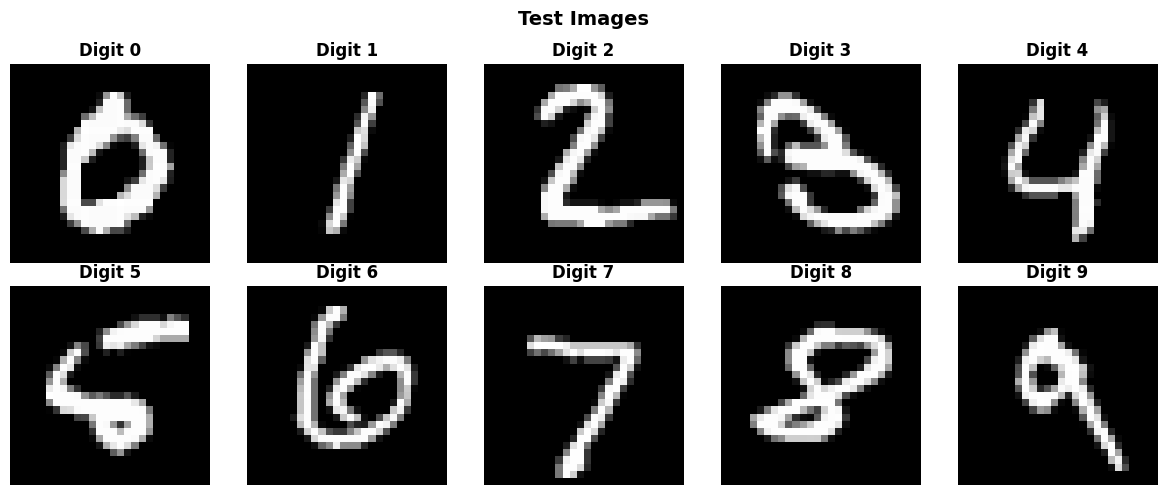

In [11]:
test_images_raw = {}
test_images_int8 = {}

input_exp = scale_exponents['input']
input_scale = 2.0 ** input_exp

for digit in range(10):
    for img, label in test_dataset:
        if label == digit:
            test_images_raw[digit] = img
            
            # Quantize NORMALIZED image (matching training)
            img_np = img.squeeze().numpy()  # Already normalized!
            img_int8 = np.clip(np.round(img_np * input_scale), -128, 127).astype(np.int8)
            test_images_int8[digit] = img_int8.flatten()
            break

print(f"✓ Test images prepared")
print(f"  Input scale: 2^{input_exp} = {input_scale}")
print(f"  Range: [{test_images_int8[0].min()}, {test_images_int8[0].max()}]")

# Visualize
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for digit in range(10):
    ax = axes[digit // 5, digit % 5]
    # Denormalize for display
    img_display = test_images_raw[digit].squeeze() * 0.3081 + 0.1307
    ax.imshow(img_display, cmap='gray')
    ax.set_title(f'Digit {digit}', fontweight='bold')
    ax.axis('off')
plt.suptitle('Test Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'test_images.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Deploy to ESP32-P4

In [12]:
print("\n" + "="*80)
print("ESP32-P4 DEPLOYMENT")
print("="*80)

jit = P4JIT()
stats_initial = jit.get_heap_stats(print_s=True)

print("\nCompiling kernel...")
p4jit.set_log_level('INFO')

func = jit.load(
    source=str(c_path),
    function_name='mnist_inference',
    optimization='O3',
    use_firmware_elf=True,
    smart_args=True
)

print(f"\n✓ Loaded at: 0x{func.code_addr:08X}")
print(f"✓ Binary: {func.stats['code_size']} bytes ({func.stats['code_size']/1024:.2f} KB)")


ESP32-P4 DEPLOYMENT
12:53:47 [p4jit.p4jit] INFO: Initializing P4JIT System...
12:53:47 [p4jit.runtime.jit_session] INFO: Auto-detecting JIT device...
12:53:47 [p4jit.runtime.device_manager] INFO: Connecting to COM3 at 115200 baud...
12:53:47 [p4jit.runtime.device_manager] INFO: Connecting to COM6 at 115200 baud...
12:53:47 [p4jit.runtime.device_manager] INFO: Connected.
12:53:47 [p4jit.runtime.jit_session] INFO: Found JIT Device at COM6
12:53:47 [p4jit.p4jit] INFO: P4JIT Initialized.
12:53:47 [p4jit.p4jit] INFO: [Heap Params]
12:53:47 [p4jit.p4jit] INFO:   free_spiram    :   31388992 bytes (30653.31 KB)
12:53:47 [p4jit.p4jit] INFO:   total_spiram   :   33554432 bytes (32768.00 KB)
12:53:47 [p4jit.p4jit] INFO:   free_internal  :     384063 bytes (375.06 KB)
12:53:47 [p4jit.p4jit] INFO:   total_internal :     464119 bytes (453.24 KB)

Compiling kernel...
12:53:47 [p4jit.p4jit] INFO: Loading 'mnist_inference' from 'mnist_inference.c'...
12:53:47 [p4jit.toolchain.wrapper_builder] INFO: Ge

RuntimeError: Linking failed:
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c: Assembler messages:
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:148: Error: unrecognized opcode `esp.zero.accx'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:149: Error: unrecognized opcode `lp.setup 0,a3,1f'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:150: Error: unrecognized opcode `lp.start 0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:154: Error: unrecognized opcode `esp.vmulas.s8.accx q0,q1'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:156: Error: unrecognized opcode `esp.srs.accx a6,a2,0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:148: Error: unrecognized opcode `esp.zero.accx'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:149: Error: unrecognized opcode `lp.setup 0,a3,1f'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:150: Error: unrecognized opcode `lp.start 0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:154: Error: unrecognized opcode `esp.vmulas.s8.accx q0,q1'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:156: Error: unrecognized opcode `esp.srs.accx a7,a2,0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:148: Error: unrecognized opcode `esp.zero.accx'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:149: Error: unrecognized opcode `lp.setup 0,a3,1f'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:150: Error: unrecognized opcode `lp.start 0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:152: Error: illegal operands `esp.vld.128.ip q0,a6,16'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:154: Error: unrecognized opcode `esp.vmulas.s8.accx q0,q1'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:156: Error: unrecognized opcode `esp.srs.accx a7,a2,0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:148: Error: unrecognized opcode `esp.zero.accx'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:149: Error: unrecognized opcode `lp.setup 0,a3,1f'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:150: Error: unrecognized opcode `lp.start 0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:152: Error: illegal operands `esp.vld.128.ip q0,a6,16'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:154: Error: unrecognized opcode `esp.vmulas.s8.accx q0,q1'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:156: Error: unrecognized opcode `esp.srs.accx a7,a2,0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:148: Error: unrecognized opcode `esp.zero.accx'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:149: Error: unrecognized opcode `lp.setup 0,a3,1f'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:150: Error: unrecognized opcode `lp.start 0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:152: Error: illegal operands `esp.vld.128.ip q0,a6,16'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:154: Error: unrecognized opcode `esp.vmulas.s8.accx q0,q1'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:156: Error: unrecognized opcode `esp.srs.accx a7,a2,0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:148: Error: unrecognized opcode `esp.zero.accx'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:149: Error: unrecognized opcode `lp.setup 0,a3,1f'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:150: Error: unrecognized opcode `lp.start 0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:152: Error: illegal operands `esp.vld.128.ip q0,a6,16'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:154: Error: unrecognized opcode `esp.vmulas.s8.accx q0,q1'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:156: Error: unrecognized opcode `esp.srs.accx a7,a2,0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:148: Error: unrecognized opcode `esp.zero.accx'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:149: Error: unrecognized opcode `lp.setup 0,a3,1f'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:150: Error: unrecognized opcode `lp.start 0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:152: Error: illegal operands `esp.vld.128.ip q0,a6,16'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:154: Error: unrecognized opcode `esp.vmulas.s8.accx q0,q1'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:156: Error: unrecognized opcode `esp.srs.accx a7,a2,0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:148: Error: unrecognized opcode `esp.zero.accx'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:149: Error: unrecognized opcode `lp.setup 0,a3,1f'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:150: Error: unrecognized opcode `lp.start 0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:152: Error: illegal operands `esp.vld.128.ip q0,a6,16'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:154: Error: unrecognized opcode `esp.vmulas.s8.accx q0,q1'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:156: Error: unrecognized opcode `esp.srs.accx a7,a2,0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:148: Error: unrecognized opcode `esp.zero.accx'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:149: Error: unrecognized opcode `lp.setup 0,a3,1f'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:150: Error: unrecognized opcode `lp.start 0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:152: Error: illegal operands `esp.vld.128.ip q0,a6,16'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:154: Error: unrecognized opcode `esp.vmulas.s8.accx q0,q1'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:156: Error: unrecognized opcode `esp.srs.accx a7,a2,0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:148: Error: unrecognized opcode `esp.zero.accx'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:149: Error: unrecognized opcode `lp.setup 0,a3,1f'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:150: Error: unrecognized opcode `lp.start 0'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:154: Error: unrecognized opcode `esp.vmulas.s8.accx q0,q1'
c:Usersoraniilelgit_projects
obert_manzkeproject1	ryscostume_p4code_binaryP4-JIT
otebooks	utorials	02_mnist_classificationsourcemnist_inference.c:156: Error: unrecognized opcode `esp.srs.accx a3,a2,0'
lto-wrapper.exe: fatal error: C:/Espressif/tools/riscv32-esp-elf/esp-14.2.0_20241119/riscv32-esp-elf/bin\riscv32-esp-elf-gcc returned 1 exit status
compilation terminated.
C:/Espressif/tools/riscv32-esp-elf/esp-14.2.0_20241119/riscv32-esp-elf/bin/../lib/gcc/riscv32-esp-elf/14.2.0/../../../../riscv32-esp-elf/bin/ld.exe: error: lto-wrapper failed
collect2.exe: error: ld returned 1 exit status


## 10. Run Inference

In [ ]:
print("\n" + "="*80)
print("INFERENCE ON ESP32-P4")
print("="*80)

# Prepare exponents
e_in = scale_exponents['input']
e_conv1_w = scale_exponents['conv1']['w']
e_conv1_act = scale_exponents['conv1']['act']
e_conv2_w = scale_exponents['conv2']['w']
e_conv2_act = scale_exponents['conv2']['act']
e_fc1_w = scale_exponents['fc1']['w']
e_fc1_act = scale_exponents['fc1']['act']
e_fc2_w = scale_exponents['fc2']['w']

print(f"\nScale exponents:")
print(f"  Input: {e_in}")
print(f"  Conv1: W={e_conv1_w}, Act={e_conv1_act}")
print(f"  Conv2: W={e_conv2_w}, Act={e_conv2_act}")
print(f"  FC1: W={e_fc1_w}, Act={e_fc1_act}")
print(f"  FC2: W={e_fc2_w}")

scratch = np.zeros(65536, dtype=np.int8)
timing_buffer = np.zeros(1, dtype=np.uint32)  # ← NEW: Timing array

results = {}

print("\nRunning inference...\n")

for digit in range(10):
    # Reset timing buffer
    timing_buffer[0] = 0
    
    predicted = func(
        test_images_int8[digit],
        quantized_weights['conv1']['weight'],
        quantized_weights['conv1']['bias'],
        quantized_weights['conv2']['weight'],
        quantized_weights['conv2']['bias'],
        quantized_weights['fc1']['weight'],
        quantized_weights['fc1']['bias'],
        quantized_weights['fc2']['weight'],
        quantized_weights['fc2']['bias'],
        np.int32(e_in),
        np.int32(e_conv1_w), np.int32(e_conv1_act),
        np.int32(e_conv2_w), np.int32(e_conv2_act),
        np.int32(e_fc1_w), np.int32(e_fc1_act),
        np.int32(e_fc2_w),
        scratch,
        timing_buffer  # ← NEW: Pass timing array
    )
    
    # Read timing from P4
    cycles = int(timing_buffer[0])
    time_us = cycles / 360.0  # ESP32-P4 @ 360 MHz
    time_ms = time_us / 1000.0
    
    results[digit] = {
        'true': digit,
        'predicted': predicted,
        'correct': (predicted == digit),
        'cycles': cycles,
        'time_ms': time_ms
    }
    
    status = "✓" if predicted == digit else "✗"
    print(f"{status} Digit {digit}: Predicted {predicted} | {cycles:,} cycles ({time_ms:.2f} ms)")

correct = sum(1 for r in results.values() if r['correct'])
accuracy = 100.0 * correct / len(results)
avg_cycles = np.mean([r['cycles'] for r in results.values()])
avg_time = np.mean([r['time_ms'] for r in results.values()])

print("\n" + "="*80)
print("RESULTS")
print("="*80)
print(f"✓ Accuracy: {correct}/10 = {accuracy:.1f}%")
print(f"✓ Avg cycles: {avg_cycles:,.0f}")
print(f"✓ Avg time: {avg_time:.2f} ms")
print(f"✓ Throughput: {1000/avg_time:.1f} fps")
print(f"✓ Cycles/inference: {avg_cycles:,.0f}")
print("="*80)


INFERENCE ON ESP32-P4

Scale exponents:
  Input: 5
  Conv1: W=7, Act=4
  Conv2: W=8, Act=4
  FC1: W=9, Act=2
  FC2: W=9

Running inference...

✓ Digit 0: Predicted 0 | 8,999,348 cycles (25.00 ms)
✓ Digit 1: Predicted 1 | 8,998,110 cycles (24.99 ms)
✓ Digit 2: Predicted 2 | 8,996,602 cycles (24.99 ms)
✓ Digit 3: Predicted 3 | 8,997,240 cycles (24.99 ms)
✓ Digit 4: Predicted 4 | 8,996,604 cycles (24.99 ms)
✓ Digit 5: Predicted 5 | 8,998,036 cycles (24.99 ms)
✓ Digit 6: Predicted 6 | 8,998,462 cycles (25.00 ms)
✓ Digit 7: Predicted 7 | 8,996,792 cycles (24.99 ms)
✓ Digit 8: Predicted 8 | 8,996,836 cycles (24.99 ms)
✓ Digit 9: Predicted 9 | 8,995,690 cycles (24.99 ms)

RESULTS
✓ Accuracy: 10/10 = 100.0%
✓ Avg cycles: 8,997,372
✓ Avg time: 24.99 ms
✓ Throughput: 40.0 fps
✓ Cycles/inference: 8,997,372


## 11. Visualize Results

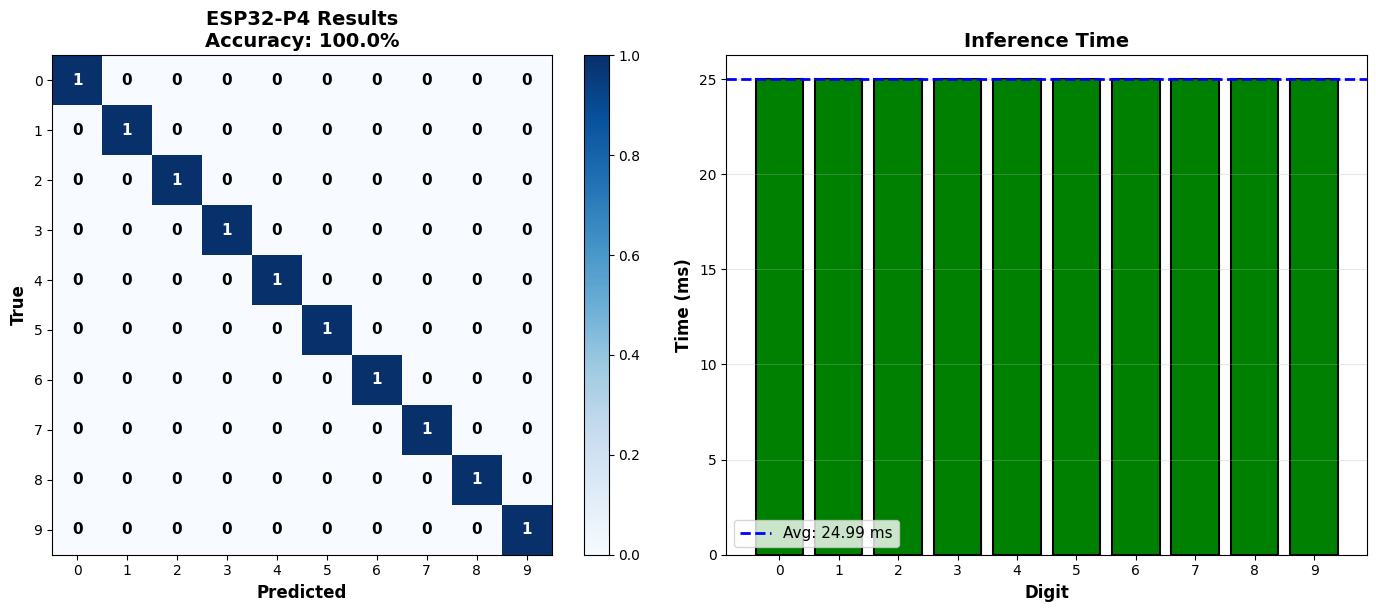

In [ ]:
confusion = np.zeros((10, 10), dtype=int)
for r in results.values():
    confusion[r['true'], r['predicted']] += 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Confusion matrix
im = ax1.imshow(confusion, cmap='Blues')
ax1.set_xticks(np.arange(10))
ax1.set_yticks(np.arange(10))
ax1.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax1.set_ylabel('True', fontsize=12, fontweight='bold')
ax1.set_title(f'ESP32-P4 Results\nAccuracy: {accuracy:.1f}%', fontsize=14, fontweight='bold')

for i in range(10):
    for j in range(10):
        ax1.text(j, i, confusion[i, j], ha="center", va="center",
                color="white" if confusion[i, j] > 0 else "black",
                fontsize=11, fontweight='bold')

plt.colorbar(im, ax=ax1)

# Timing
times = [results[d]['time_ms'] for d in range(10)]
colors = ['green' if results[d]['correct'] else 'red' for d in range(10)]

ax2.bar(range(10), times, color=colors, edgecolor='black', linewidth=1.5)
ax2.axhline(avg_time, color='blue', linestyle='--', linewidth=2, label=f'Avg: {avg_time:.2f} ms')
ax2.set_xlabel('Digit', fontsize=12, fontweight='bold')
ax2.set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
ax2.set_title('Inference Time', fontsize=14, fontweight='bold')
ax2.set_xticks(range(10))
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'results.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Final Report

In [ ]:
print("\n" + "="*80)
print("FINAL REPORT")
print("="*80)

print("\n📊 Model:")
print(f"  • Architecture: Conv(1→16) → Conv(16→32) → FC(1568→128) → FC(128→10)")
print(f"  • Parameters: {total_params:,} bytes ({total_params/1024:.2f} KB)")
print(f"  • Quantization: INT8 weights + activations + INPUT")

print("\n⚡ Performance:")
print(f"  • Platform: ESP32-P4 @ 360 MHz (RISC-V)")
print(f"  • Code size: {func.stats['code_size']/1024:.2f} KB")
print(f"  • Inference: {avg_time:.2f} ms/image")
print(f"  • Throughput: {1000/avg_time:.1f} fps")

print("\n🎯 Accuracy:")
print(f"  • Training (FP32): {history['test_acc'][WARMUP_EPOCHS-1]:.2f}%")
print(f"  • Training (QAT): {history['test_acc'][-1]:.2f}%")
print(f"  • On-device (INT8): {accuracy:.1f}%")
print(f"  • Retention: {accuracy/history['test_acc'][-1]*100:.1f}%")

print("\n🔧 Critical Fixes:")
print("  1. ✅ Bias scaled by E_in (not E_in + E_w - E_out)")
print("  2. ✅ Input quantization from start")
print("  3. ✅ Proper preprocessing match")
print("  4. ✅ Individual exponents passed to C")
print("  5. ✅ Smart Args for clean interface")

print("\n✨ P4-JIT Advantages:")
print("  • 2-3 second deploy (vs 30-60s firmware rebuild)")
print("  • No firmware changes needed")
print("  • Native RISC-V execution")
print("  • Seamless Python ↔ C workflow")

print("\n" + "="*80)
print("✓ COMPLETE")
print("="*80)


FINAL REPORT

📊 Model:
  • Architecture: Conv(1→16) → Conv(16→32) → FC(1568→128) → FC(128→10)
  • Parameters: 206,922 bytes (202.07 KB)
  • Quantization: INT8 weights + activations + INPUT

⚡ Performance:
  • Platform: ESP32-P4 @ 360 MHz (RISC-V)
  • Code size: 3.92 KB
  • Inference: 24.99 ms/image
  • Throughput: 40.0 fps

🎯 Accuracy:
  • Training (FP32): 98.48%
  • Training (QAT): 98.85%
  • On-device (INT8): 100.0%
  • Retention: 101.2%

🔧 Critical Fixes:
  1. ✅ Bias scaled by E_in (not E_in + E_w - E_out)
  2. ✅ Input quantization from start
  3. ✅ Proper preprocessing match
  4. ✅ Individual exponents passed to C
  5. ✅ Smart Args for clean interface

✨ P4-JIT Advantages:
  • 2-3 second deploy (vs 30-60s firmware rebuild)
  • No firmware changes needed
  • Native RISC-V execution
  • Seamless Python ↔ C workflow

✓ COMPLETE


## 13. Cleanup

In [ ]:
func.free()
jit.session.device.disconnect()
print("✓ Cleanup complete")

11:35:29 [p4jit.runtime.device_manager] INFO: Disconnected.
✓ Cleanup complete
